In [1]:
import sys
sys.path.append("../../")

# Reproduction of Figure 3 using a GP model

Here I reproduce Figure 3 of Garnelo et al.'s article, using a Gaussian Process (GP) model instead of a Neural Process (NP). 
This mainly serves as a sanity check and a proof of concept for the general structure of my code.

In [2]:
import tensorflow as tf

from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

We sample functions from a GP with a squared-exponential kernel. For the latter, the correlation length is 10, and the other parameters are default values.

In [3]:
kernel = lambda x: squared_exponential_kernel(x, 2., 1., 0.02)
distribution = lambda x: GaussianProcess((None, x), kernel, name="distr")

Now we construct the `DataProvider` module, which acts as an interface between the distribution and the model.

In [4]:
data_provider = DataProvider(distribution, batch_size=2, domain=(-2, 2))

The `data_provider` now generates `batch_size` example ground truth functions, sampled from the `distribution`.
The `data_for_plotting` property returns two lists of points.
The first list contains 100 uniformly random distributed x-coordinates and the corresponding y-values of the ground truth functions.
The second list contains 100 x-coordinates that are evenly spaced throughout the function domain and their corresponding y-values of the ground truth functions.
We name the two lists `context_points` and `target_points`, respectively.

In [5]:
data = data_provider.data

Like `context_points`, `target_points` is a tuple of two tensors: the x-coordinates and the y-values.
We will need both individually.

In [6]:
x_target = data.queries[1]
y_target = data.targets

# Transform to [B, n, 2] tensor, where n is the number of context points in each batch (good for plotting)
targets = tf.transpose([x_target, y_target], perm=[1, 2, 0])

Pick a few context points.

In [7]:
num_context = 3

r = tf.random_shuffle(tf.range(tf.shape(x_target)[1]))
x_context = tf.gather(x_target, r, axis=1)[:, :num_context]
y_context = tf.gather(y_target, r, axis=1)[:, :num_context]

context_points = tf.transpose([x_context, y_context], perm=[1, 2, 0])

In contrast to the NP model, the GP model does not need to be trained, since we use the same kernel for data generation and for the model.
Thus, we create a GP model and provide it with a variable number of context points, as well as the `kernel` defined above.

In [8]:
model = GaussianProcess(((x_context, y_context), x_target), kernel, name="model")

In [9]:
# Transform to [B, n, 2] tensor, where n is the number of context points in each batch (good for plotting)
predictions = tf.transpose([x_target, model.sample], perm=[1, 2, 0])

For each ground truth, we now sample XXXX functions from the conditioned GP model and compare them visually to the ground truth function.

In [10]:
with tf.Session() as session:
    t, c, p = session.run([targets, context_points, predictions], feed_dict={data_provider.plotting_mode: True})

In [11]:
from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

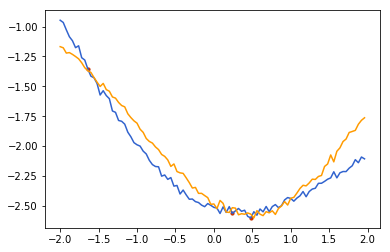

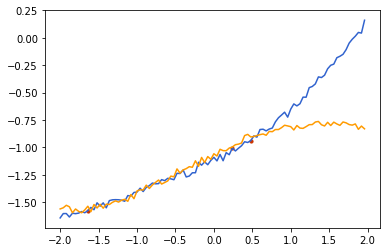

In [12]:
for i in range(2):
    list_plot([c[i], t[i], p[i]], joined=[False, True, True], mesh=[True, False, False])